In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path
import statsmodels.api as sm

In [2]:
# Load options data, original format
df_option = pd.read_parquet(os.path.join(data_path, 'SPY_options.parquet'))
df_option = df_option[df_option['EXPIRE_DATE'] != '2015-12-19']
df_option = df_option[df_option['EXPIRE_DATE'] != '2018-12-23']
df_option.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,C_BID,C_ASK,C_SIZE,...,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME
0,2010-01-04,113.29,2010-01-15,11.0,55.0,58.3,0.515,58.20,58.40,305 x 270,...,0.02,0 x 1268,0.02,-0.00143,0.00010,0.00074,-0.00435,-0.00050,1.36742,0.0
1,2010-01-04,113.29,2010-01-15,11.0,56.0,57.3,0.506,57.20,57.40,305 x 270,...,0.01,0 x 1269,0.00,-0.00160,0.00020,0.00074,-0.00396,-0.00043,1.33476,NaN
2,2010-01-04,113.29,2010-01-15,11.0,57.0,56.3,0.497,56.20,56.39,305 x 270,...,0.01,0 x 1268,0.03,-0.00146,0.00014,0.00106,-0.00369,-0.00004,1.30655,0.0
3,2010-01-04,113.29,2010-01-15,11.0,58.0,55.3,0.488,55.19,55.40,304 x 269,...,0.03,0 x 1269,0.04,-0.00166,0.00017,0.00056,-0.00428,-0.00051,1.27237,0.0
4,2010-01-04,113.29,2010-01-15,11.0,59.0,54.3,0.479,54.20,54.40,304 x 269,...,0.02,0 x 1268,0.04,-0.00167,0.00016,0.00128,-0.00429,-0.00023,1.24421,0.0


In [3]:
# Load SPY price data
df_stock = pd.read_pickle(os.path.join(data_path, 'spy_1d.pkl'))
df_stock['ts'] = pd.to_datetime(df_stock['ts'].dt.date)
df_stock = df_stock[(df_stock['ts']>='2010-01-01')&(df_stock['ts']<='2022-12-31')]

df_stock.head()

,ts,close_price
2507,2010-01-04,113.330002
2508,2010-01-05,113.629997
2509,2010-01-06,113.709999
2510,2010-01-07,114.190002
2511,2010-01-08,114.570000


In [4]:
# Load squuezemetric data
df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
df_sq = df_sq[(df_sq['date']>='2011-02-05')&(df_sq['date']<='2022-12-31')]
df_sq.head()

,date,price,dix,gex
0,2011-05-02,1361.219971,0.378842,1.897313e+09
1,2011-05-03,1356.619995,0.383411,1.859731e+09
2,2011-05-04,1347.319946,0.392122,1.717764e+09
3,2011-05-05,1335.099976,0.405457,1.361864e+09
4,2011-05-06,1340.199951,0.418649,1.490329e+09


In [5]:
# option filtering
flt_option = df_option.dropna(subset=['C_LAST', 'P_LAST']) # clean NaN value
flt_option = flt_option.rename(columns={'QUOTE_DATE': 'date'})
'''
flt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option
flt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date
'''

"\nflt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option\nflt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date\n"

delta-neutral price using put-call parity

In [ ]:
r = 0.03 # or can be pull from other data source
strike = flt_option['STRIKE']
T = flt_option['DTE']/365
call_price = flt_option['C_LAST']
put_price = flt_option['P_LAST']

# calculate delta_neutral for each option price using put call parity
flt_option['delta_neutral_price'] = strike + np.exp(r * T) * (call_price - put_price)

# !! maybe should use SOME KIND OF weighted average approach based on oi or moneyness


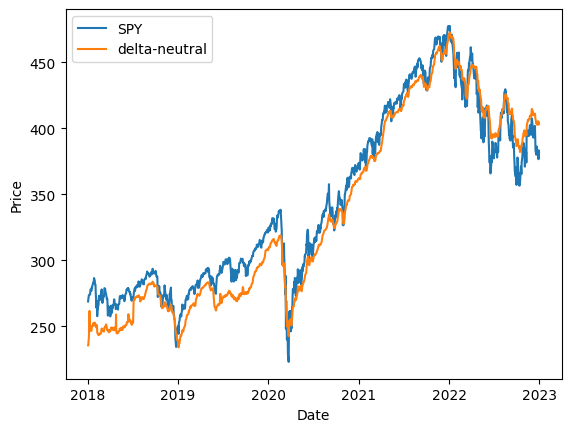

In [7]:
dn_price = flt_option.groupby('date')['delta_neutral_price'].mean().reset_index()
stock_price = df_stock.rename(columns={'ts': 'date'})

# plot spy and delta neutral price
# earliest data: 2010, latest data: 2022
starting_date = '2018-01-01'
ending_date = '2022-12-31'

plt.plot(stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['date'], stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['date'], dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['delta_neutral_price'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

calculate gamma, need oi data. we also have gex from squeezemetric

In [8]:
# open interest. we assume to use volume now
flt_option['C_OI'] = flt_option['C_VOLUME'].fillna(0)
flt_option['P_OI'] = flt_option['P_VOLUME'].fillna(0)

In [9]:
# calculate gamma exposure 
contract_size = 100
flt_option['C_gamma_exposure'] = flt_option['C_GAMMA'] * contract_size * flt_option['C_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01
flt_option['P_gamma_exposure'] = flt_option['P_GAMMA'] * contract_size * flt_option['P_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01

call_gamma = flt_option.groupby('date')['C_gamma_exposure'].sum()
put_gamma = flt_option.groupby('date')['P_gamma_exposure'].sum()

gamma_exposure = pd.DataFrame({'GEX': call_gamma - put_gamma,'GEX_Skew': (call_gamma - put_gamma)/(call_gamma + put_gamma)}).reset_index()
gamma_exposure.head()

,date,GEX,GEX_Skew
0,2010-01-04,-1.400059e+06,-0.105897
1,2010-01-05,-2.141322e+06,-0.135393
2,2010-01-06,-3.535363e+06,-0.275775
3,2010-01-07,-2.346442e+06,-0.143924
4,2010-01-08,-2.670400e+06,-0.188442


In [10]:
# squeezemetric gex
gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]

In [11]:
# time series of date with delta-adjusted and gamma exposure

df_1 = pd.merge(stock_price, dn_price, on='date')
df_1['delta_adjusted'] = df_1['close_price'] - df_1['delta_neutral_price']
df_2 = pd.merge(df_1, gex_sq, on='date')

df_3 = pd.merge(df_2, gamma_exposure, on='date')

df_time = df_3[['date', 'delta_adjusted', 'gex_sq','GEX','GEX_Skew']]

some testing, currently the relationship is poor, we dont have oi data for gex skew calculation.

In [12]:
# linear regression of delta_adjusted price and gex_sq

X = df_time['gex_sq']
y = df_time['delta_adjusted']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         delta_adjusted   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     253.2
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           9.99e-55
Time:                        02:17:52   Log-Likelihood:                -10964.
No. Observations:                2906   AIC:                         2.193e+04
Df Residuals:                    2904   BIC:                         2.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8052      0.266     40.568      0.0

In [13]:
# compare calculation of gex_sq with GEX (our calculation)
X = df_time['GEX']
y = df_time['gex_sq']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 gex_sq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.464
Date:                Sat, 05 Apr 2025   Prob (F-statistic):            0.00365
Time:                        02:17:52   Log-Likelihood:                -67378.
No. Observations:                2906   AIC:                         1.348e+05
Df Residuals:                    2904   BIC:                         1.348e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.629e+09   5.27e+07     49.874      0.0

the below is personal trial for alternative way to obtain delta-neutral price by calculating delta exposure. not looking good. a lot of iv is nan

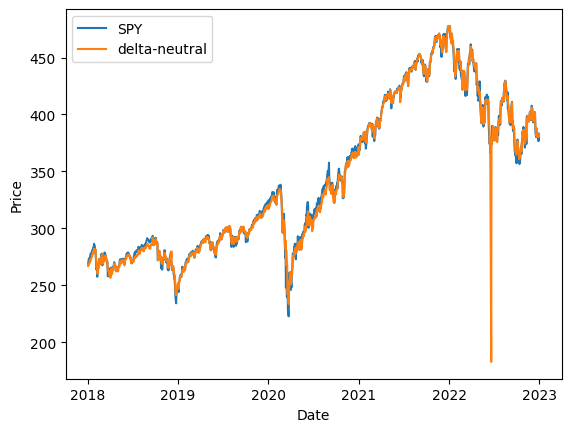

In [14]:

from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes delta formulas
def net_market_delta(S, group, r):
    K = group['STRIKE'].values
    T = group['DTE'].values / 365
    c_sigma = group['C_IV'].values
    p_sigma = group['P_IV'].values
    c_oi = group['C_OI'].values
    p_oi = group['P_OI'].values

    # Compute d1 for calls and puts
    d1_call = (np.log(S / K) + (r + 0.5 * c_sigma**2) * T) / (c_sigma * np.sqrt(T))
    d1_put  = (np.log(S / K) + (r + 0.5 * p_sigma**2) * T) / (p_sigma * np.sqrt(T))

    # Compute deltas
    delta_c = norm.cdf(d1_call)
    delta_p = norm.cdf(d1_put) - 1

    # Net delta
    total = np.sum(c_oi * delta_c + p_oi * delta_p)
    return total

def solve_delta_neutral(group, r=0.01):
    # Filter out bad rows
    group = group[
        (group['C_IV'] > 0) &
        (group['P_IV'] > 0) &
        (group['DTE'] > 0) &
        (group['STRIKE'] > 0)
    ].copy()

    if group.empty:
        return np.nan

    mid_price = group['UNDERLYING_LAST'].iloc[0]
    low, high = mid_price * 0.5, mid_price * 1.5

    try:
        delta_low = net_market_delta(low, group, r)
        delta_high = net_market_delta(high, group, r)
        #print(group['date'].iloc[0], f"Net Delta @ Low={delta_low}, High={delta_high}")
        return brentq(lambda S: net_market_delta(S, group, r), low, high)
    except ValueError:
        return np.nan

    

f = flt_option.groupby('date').apply(solve_delta_neutral).reset_index()
f.columns = ['date', 'delta_neutral']


dn_price = f
stock_price = df_stock.rename(columns={'ts': 'date'})

# plot spy and delta neutral price
# earliest data: 2010, latest data: 2022
starting_date = '2018-01-01'
ending_date = '2022-12-31'

plt.plot(stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['date'], stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['date'], dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['delta_neutral'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


